In [69]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

plt.style.use('ggplot')

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

In [70]:
from helper import get_confusion_matrix, model_results

In [71]:
train_data = pd.read_csv("train_sampled.csv", index_col=0)

In [72]:
train_data

,INDEX,Provider,PotentialFraud,DaysAdmitted,InscCoveredPercent,TotalClaimAmount,DailyTotalCharge,TotalAnnClaimAmt,NumOfDoctors,NumOfPatients,ServiceType,NumOfClms,numStates,numCounties,AvgChronic,AvgClaim,NumUniqClmAdmitDiagCOde,NumUniqGroupDiagCode,AvgAgeWhenServed,NumOfDuplicatedBeneID,NumOfDuplicatedAttendingPhysician,NumOfDuplicatedClaims,ChronicCond0,ChronicCond1,ChronicCond2,ChronicCond3,ChronicCond4,ChronicCond5,ChronicCond6,ChronicCond7,ChronicCond8,ChronicCond9,ChronicCond10,ChronicCond11,ChronicCond12,Gender1,Gender2,Race1,Race2,Race3,Race5,NumDistincOpPhy,NumDistincOtherPhy
0,PRV51001,PRV51001,0,2.440000,0.975656,4399.200000,1061.072000,21582.240000,14,24,both,25,1,7,5.888889,2.777778,11.0,5.0,77.729167,0.0,3.0,11.0,0.0,1.0,0.0,2.0,4.0,2.0,6.0,4.0,3.0,1.0,0.0,1.0,0.0,9,15,20,4,0,0,5.0,8.0
1,PRV51003,PRV51003,1,4.674242,0.912167,5090.575758,1298.615410,11914.909091,44,117,both,132,3,23,5.000000,12.000000,58.0,58.0,68.485755,0.0,3.0,25.0,7.0,1.0,14.0,22.0,15.0,20.0,12.0,11.0,8.0,5.0,2.0,0.0,0.0,49,68,94,22,0,1,7.0,22.0
2,PRV51004,PRV51004,0,2.429530,0.978485,352.214765,250.363050,7604.483221,38,138,outpatient,149,9,28,4.500000,14.900000,25.0,0.0,71.937802,2.0,16.0,72.0,8.0,12.0,13.0,27.0,11.0,16.0,18.0,11.0,12.0,8.0,2.0,0.0,0.0,45,93,113,20,5,0,19.0,26.0
3,PRV51005,PRV51005,1,2.088412,0.980747,244.300429,196.533055,6749.216309,6,495,outpatient,1165,4,26,4.500000,116.500000,158.0,0.0,69.503649,113.0,6.0,530.0,38.0,52.0,57.0,72.0,69.0,55.0,59.0,48.0,27.0,17.0,1.0,0.0,0.0,208,287,382,110,3,0,6.0,4.0
4,PRV51007,PRV51007,0,1.958333,0.985303,513.527778,243.681944,5694.444444,10,58,both,72,2,6,4.000000,8.000000,17.0,3.0,67.491379,3.0,3.0,29.0,5.0,5.0,8.0,7.0,8.0,8.0,5.0,6.0,6.0,0.0,0.0,0.0,0.0,27,31,47,11,0,0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,PRV56231,PRV56231,1,2.322222,0.965379,1642.577778,500.431683,7450.222222,23,198,both,270,2,24,4.500000,27.000000,67.0,30.0,71.305135,8.0,12.0,105.0,12.0,13.0,21.0,28.0,25.0,30.0,25.0,26.0,11.0,7.0,0.0,0.0,0.0,78,120,146,49,3,0,20.0,8.0
9804,PRV51067,PRV51067,1,3.310345,0.960767,5993.379310,1168.244203,15097.068966,21,49,both,58,1,8,4.000000,6.444444,16.0,12.0,67.251701,3.0,6.0,26.0,2.0,6.0,4.0,6.0,5.0,8.0,6.0,7.0,4.0,1.0,0.0,0.0,0.0,15,34,37,12,0,0,5.0,14.0
9805,PRV54875,PRV54875,1,10.150000,0.757172,9489.052632,1509.637295,16683.400000,3,19,inpatient,20,1,8,4.750000,2.500000,18.0,20.0,70.000000,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,8,11,14,0,1,4,2.0,3.0
9806,PRV52308,PRV52308,1,3.954023,0.908435,4800.000000,1005.562183,15637.540230,41,72,both,87,2,15,4.500000,8.700000,41.0,37.0,70.686111,1.0,3.0,18.0,4.0,4.0,3.0,9.0,11.0,11.0,4.0,12.0,7.0,5.0,2.0,0.0,0.0,30,42,56,16,0,0,23.0,20.0


## Dummify `ServiceType`

In [73]:
# Dummify the ServiceType
dummy = pd.get_dummies(train_data['ServiceType'], drop_first=True)

train_data2= pd.concat([train_data, dummy], axis=1).drop('ServiceType', axis=1)

## Scale features

In [74]:
#Scale the features
X= train_data2.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
scaled_X = scale(X)
Y= train_data2['PotentialFraud']

## Train-test split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

## Logistic regression with $\ell_1$-penalty

In [76]:
logit=LogisticRegression(solver='liblinear', penalty='l1')

grid_param = [{
    "C": np.logspace(-1, 1, 10)
   }]

In [77]:
logit_search= GridSearchCV(logit, param_grid=grid_param, scoring='accuracy', cv=5,
                          return_train_score=True)
logit_search= logit_search.fit(X_train, y_train)

In [78]:
print(logit_search.best_params_)
print(logit_search.best_score_)

{'C': 2.1544346900318834}
0.8669397928819931


In [79]:
model_results(X_train, y_train, X_test, y_test, logit_search, show=True)

The Model Results for  GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid=[{'C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])}],
             return_train_score=True, scoring='accuracy')
************************************************************
Train Accuracy is equal to 0.867
Test Accuracy is equal to 0.862
The Precision score is 0.854
The Average Precision score is 0.810
The Recall score is 0.874
The F1 score is 0.864
The AUC/ROC score is 0.862
True-Positive: 857.000
True-Negative: 835.000
False-Positive: 146.000
False-Negative: 124.000
Correctly Classified: 1692.000
Incorrectly Classified: 270.000


[0.8668111139434107, 0.8623853211009175, 0.8544366899302094, 0.873598369011213]

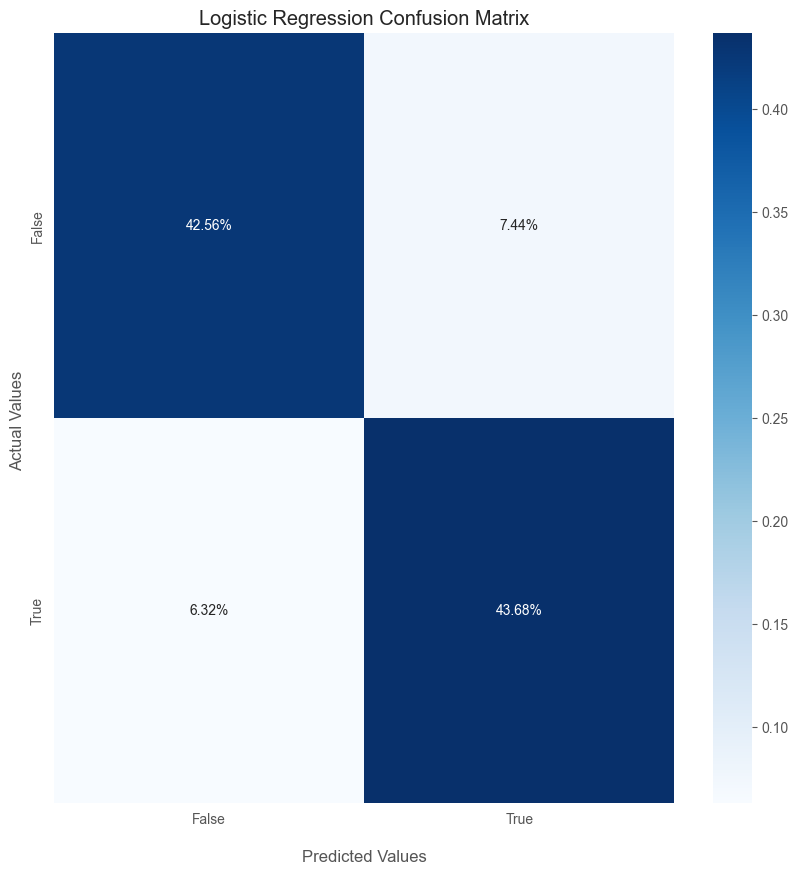

In [80]:
cm = get_confusion_matrix(logit_search, X_test, y_test)

labels = ['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Logistic Regression Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FNR: 7.44%, TPR: 6.32%

## SHAP plots

In [81]:
import shap
sns.set_style("whitegrid")

explainer = shap.LinearExplainer(logit_search.best_estimator_, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

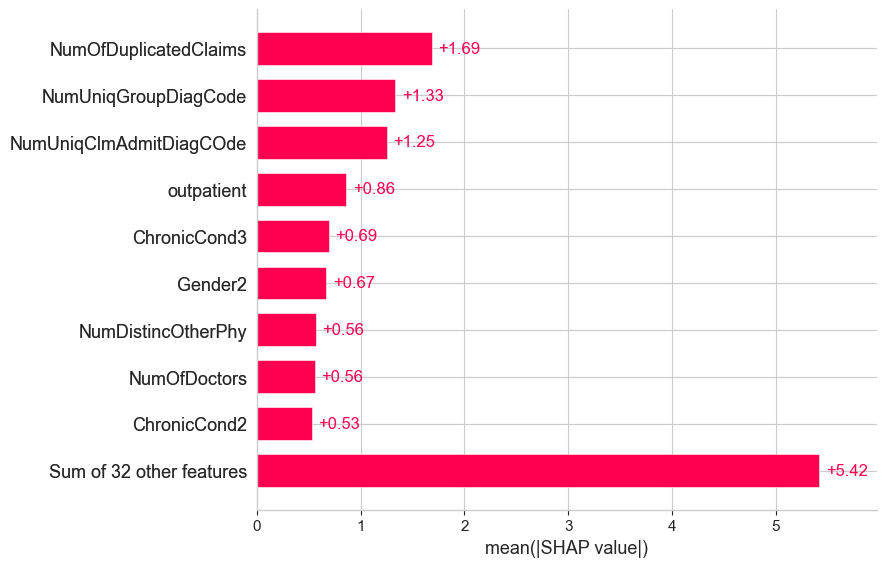

In [82]:
shap.plots.bar(shap_values)